# Pytorch Image Classfication

In [133]:
# Imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import glob 
import random 

from PIL import Image
import cv2

import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
from torchvision import transforms
from torch.utils.data import DataLoader

import shap
from sklearn import metrics
from sklearn.metrics import precision_recall_fscore_support as score
from sklearn.metrics import ConfusionMatrixDisplay as cmd

## Dataset

In [ ]:
def plot_img(path):

    img_name = path.split("/")[-1]
    target = int(img_name.split("_")[0])
    img =  Image.open(path)

    if target == 0: 
      print('GO')
    else: 
      print('STOP')
    
    plt.imshow(img)

    return img, target

STOP


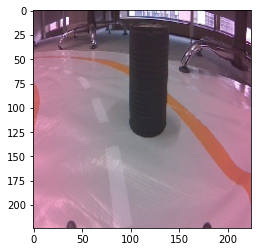

In [51]:
read_path = glob.glob("../../data/object_detection/*.jpg")

# Plot a random image
path = random.choice(read_path)
img, target = plot_img(path)

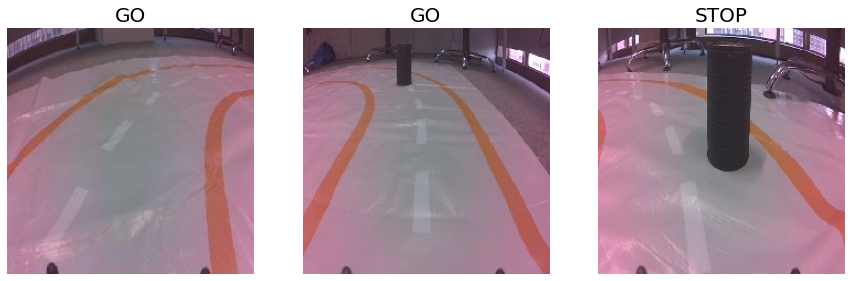

In [61]:
# Paths of example images
ex_paths = ["../../data/object_detection/0_b812cd70-4eff-11ed-9b15-f602a686e36d.jpg",
          "../../data/object_detection/0_d1edcc80-4ef6-11ed-8ddf-a46bb6070c92.jpg",
          "../../data/object_detection/1_cb171726-4ef7-11ed-8ddf-a46bb6070c92.jpg"]

# Plot example images
fig, ax = plt.subplots(1, 3, figsize=(15, 5))
fig.set_facecolor('white')

for i, path in enumerate(ex_paths):
    
    # Load image
    img =  Image.open(path)

    # Get target
    name = path.split("/")[-1]
    target = int(name.split("_")[0])

    # Plot image
    ax[i].imshow(img)
    ax[i].axis("off")

    # Set title
    title = ["GO","STOP"][target]
    ax[i].set_title(title,size=20)


## Simple Heuristic

In [108]:
def threshold(img,cutoff,invert=False):
    """Apply intesity thresholding"""
    
    img = np.array(img)
    img = cv2.cvtColor(img,cv2.COLOR_RGB2GRAY)
    
    #Apply cutoff
    img[img>cutoff] = 255 #white
    img[img<=cutoff] = 0 #black

    # Scale to 0-1    
    img = img/255

    # Invert image to black = 1
    if invert: 
        img = 1 - img

    return img

40021.0
0.7976124043367347
0.8562659438775511


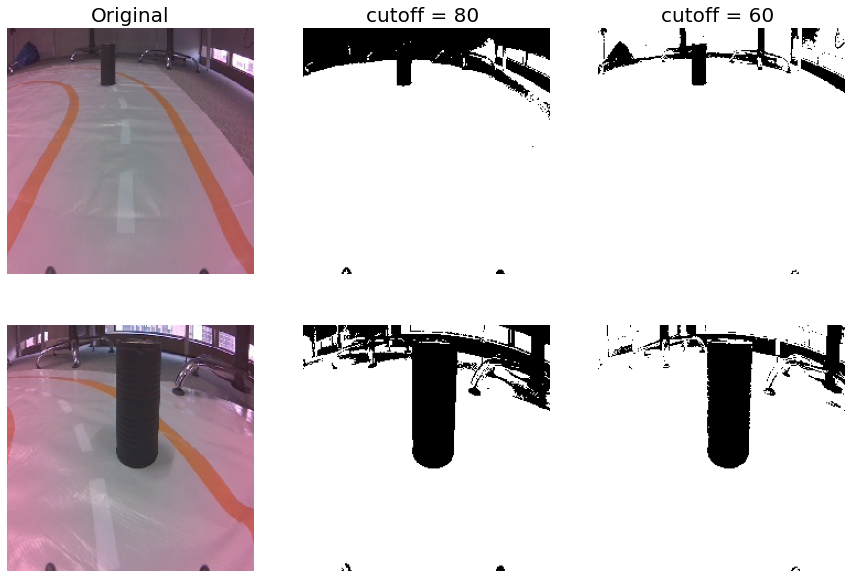

In [120]:
img1 = Image.open(ex_paths[1])
img2 = Image.open(ex_paths[2])

#Display images
fig,ax = plt.subplots(2,3,figsize=(15,10))
fig.patch.set_facecolor('xkcd:white')

ax[0,0].imshow(img1) 
ax[0,0].set_title("Original",size=20)

ax[0,1].imshow(threshold(img1,80),cmap='gray') 
ax[0,1].set_title("cutoff = 80 ",size=20)

ax[0,2].imshow(threshold(img1,60),cmap='gray') 
ax[0,2].set_title("cutoff = 60 ",size=20)


ax[1,0].imshow(img2) 
ax[1,1].imshow(threshold(img2,80),cmap='gray') 
print(np.sum(threshold(img2,80)))
print(np.average(threshold(img2,80)))
ax[1,2].imshow(threshold(img2,60),cmap='gray') 
print(np.average(threshold(img2,60)))

for a1 in ax:
    for a2 in a1:
        a2.axis('off')

In [100]:
# Load paths
paths = glob.glob("../../data/object_detection/*.jpg")

# Load images and targets
images = [Image.open(path) for path in paths]
target = [int(path.split("/")[-1].split("_")[0]) for path in paths]

# Apply thresholding and get intensity
thresh_img = [threshold(img,60,True) for img in images]
intensity = [np.average(img) for img in thresh_img]

0.04539162806262615
0.1221177474864334


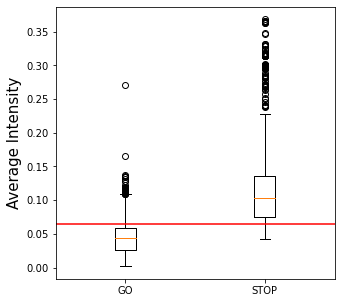

In [71]:
# Split data into go and stop images
go_data = [intensity[i] for i in range(len(target)) if target[i]==0]
stop_data = [intensity[i] for i in range(len(target)) if target[i]==1]
data= [go_data,stop_data]

fig = plt.figure(figsize=(5,5))
fig.set_facecolor('white')

plt.boxplot(data)
plt.hlines(y=0.065,xmin=0.5,xmax=2.5,color='r')
plt.xticks([1,2],['GO','STOP'])
plt.ylabel("Average Intensity",size=15)

print(np.average(go_data))
print(np.average(stop_data))

Accuracy: 0.82
Precision: 0.771
Recall: 0.8296


<Figure size 360x360 with 0 Axes>

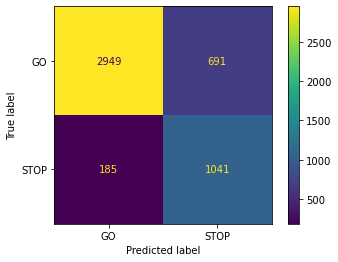

In [95]:
# Predict using average intensity
prediction = [1 if i>0.065 else 0 for i in intensity]

# Evaluate
acc = metrics.accuracy_score(target,prediction)
prec,rec,_,_ = score(target, prediction,average='macro')

print('Accuracy: {}'.format(round(acc,4)))
print('Precision: {}'.format(round(prec,4)))
print('Recall: {}'.format(round(rec,4)))

fig = plt.figure(figsize=(5,5))
fig.set_facecolor('white')

# Plot confusion matrix
cm = metrics.confusion_matrix(target, prediction)
cm_display = cmd(cm, display_labels = ['GO', 'STOP'])

cm_display.plot()

path = "/Users/conorosullivan/Google Drive/My Drive/Medium/PyTorch Classification/thresh_cm.png"
plt.savefig(path,facecolor='white',bbox_inches='tight')

## Convolutional Neural Network

In [145]:
class ImageDataset(torch.utils.data.Dataset):
    def __init__(self, paths, transform):

        self.transform = transform
        self.paths = paths

    def __getitem__(self, idx):
        """Get image and target (x, y) coordinates"""

        # Read image
        path = self.paths[idx]
        image = cv2.imread(path, cv2.IMREAD_COLOR)
        image = Image.fromarray(image)

        # Transform image
        image = self.transform(image)
        
        # Get target
        target = path.split("/")[-1].split("_")[0]
        target = [[1,0],[0,1]][int(target)]

        target = torch.Tensor(target)

        return image, target

    def __len__(self):
        return len(self.paths)


In [146]:
TRANSFORMS = transforms.Compose([
    transforms.ColorJitter(0.2, 0.2, 0.2, 0.2),
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

paths = glob.glob("../../data/object_detection/*.jpg")

# Shuffle the paths
random.seed(100)
random.shuffle(paths)

# Create a datasets for training and validation
split = int(0.8 * len(paths))
train_data = ImageDataset(paths[:split], TRANSFORMS)
valid_data = ImageDataset(paths[split:], TRANSFORMS)

# Prepare data for Pytorch model
train_loader = DataLoader(train_data, batch_size=128, shuffle=True)
valid_loader = DataLoader(valid_data, batch_size=valid_data.__len__())

# Dataset lengths
print("Train dataset length: {}".format(train_data.__len__()))
print("Validation dataset length: {}".format(valid_data.__len__()))

Train dataset length: 3892
Validation dataset length: 974


In [147]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()

        # Convolutional layers
        self.conv_layers = nn.Sequential(
            # Sees 224x224x3 image tensor
            nn.Conv2d(3, #RGB channels
                            16, #number of kernels
                            3, #size of kernels
                            padding=1), 
            nn.MaxPool2d(2),
            nn.ReLU(),

            # Sees 112x112x16 tensor
            nn.Conv2d(16, 32, 3, padding=1),
            nn.MaxPool2d(2),
            nn.ReLU(),

            # Sees 56x56x32 tensor
            nn.Conv2d(32, 64, 3, padding=1),
            nn.MaxPool2d(2),
            nn.ReLU()
        )

        # Fully connected layers
        self.fc_layers = nn.Sequential(
            # Sees flattened 28 * 28 * 64 tensor
            nn.Dropout(0.25),
            nn.Linear(64 * 28 * 28, 500),
            nn.ReLU(),
            nn.Linear(500, 2),
            nn.Sigmoid()
        )

    def forward(self, x):
        x = self.conv_layers(x)
        x = x.view(-1, 64 * 28 * 28)
        x = self.fc_layers(x)
        return x

In [148]:
# create a complete CNN
model = Net()
print(model)

# move tensors to GPU if available
device = torch.device('mps')
model.to(device)

# specify loss function (binary cross-entropy)
criterion = nn.BCELoss()

# specify optimizer
optimizer = torch.optim.Adam(model.parameters())

Net(
  (conv_layers): Sequential(
    (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (2): ReLU()
    (3): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): ReLU()
    (6): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (8): ReLU()
  )
  (fc_layers): Sequential(
    (0): Dropout(p=0.25, inplace=False)
    (1): Linear(in_features=50176, out_features=500, bias=True)
    (2): ReLU()
    (3): Linear(in_features=500, out_features=2, bias=True)
    (4): Sigmoid()
  )
)


In [149]:
name = "object_detection_cnn" # Change this to save a new model

# Train the model
min_loss = np.inf
for epoch in range(20):

    model = model.train()
    for images, target in iter(train_loader):

        images = images.to(device)
        target = target.to(device)
        
        # Zero gradients of parameters
        optimizer.zero_grad()  

        # Execute model to get outputs
        output = model(images)

        # Calculate loss
        loss = criterion(output, target)

        # Run backpropogation to accumulate gradients
        loss.backward()

        # Update model parameters
        optimizer.step()

    # Calculate validation loss
    model = model.eval()

    images, target = next(iter(valid_loader))
    images = images.to(device)
    target = target.to(device)

    output = model(images)
    valid_loss = criterion(output, target)

    print("Epoch: {}, Validation Loss: {}".format(epoch, valid_loss.item()))
    
    if valid_loss < min_loss:
        print("Saving model")
        torch.save(model, '../../models/{}.pth'.format(name))

        min_loss = valid_loss

Epoch: 0, Validation Loss: 0.35913583636283875
Saving model
Epoch: 1, Validation Loss: 0.14938828349113464
Saving model
Epoch: 2, Validation Loss: 0.15897515416145325
Epoch: 3, Validation Loss: 0.0980810895562172
Saving model
Epoch: 4, Validation Loss: 0.08344855159521103
Saving model
Epoch: 5, Validation Loss: 0.07082481682300568
Saving model
Epoch: 6, Validation Loss: 0.0674619972705841
Saving model
Epoch: 7, Validation Loss: 0.05836256593465805
Saving model
Epoch: 8, Validation Loss: 0.07650061696767807
Epoch: 9, Validation Loss: 0.05039908364415169
Saving model
Epoch: 10, Validation Loss: 0.056112319231033325
Epoch: 11, Validation Loss: 0.04313705489039421
Saving model
Epoch: 12, Validation Loss: 0.04768643528223038
Epoch: 13, Validation Loss: 0.0401008203625679
Saving model
Epoch: 14, Validation Loss: 0.04340188950300217
Epoch: 15, Validation Loss: 0.07657178491353989
Epoch: 16, Validation Loss: 0.042294539511203766
Epoch: 17, Validation Loss: 0.0467371940612793
Epoch: 18, Validat

In [150]:
# Load saved model 
model = torch.load('../../models/object_detection_cnn.pth')
model.eval()
model.to(device)

# Get images and targets
images, target = next(iter(valid_loader))
target = [int(t[1]) for t in target]

# Get predictions
images = images.to(device)
output=model(images)
prediction = [0 if o[0] > 0.5 else 1 for o in output ]

Accuracy: 0.9805
Precision: 0.9722
Recall: 0.9797


<Figure size 360x360 with 0 Axes>

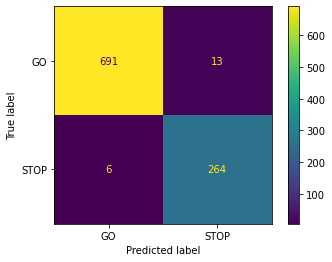

In [151]:
# Evaluate
acc = metrics.accuracy_score(target,prediction)
prec,rec,_,_ = score(target, prediction,average='macro')

print('Accuracy: {}'.format(round(acc,4)))
print('Precision: {}'.format(round(prec,4)))
print('Recall: {}'.format(round(rec,4)))

fig = plt.figure(figsize=(5,5))
fig.set_facecolor('white')

# Plot confusion matrix
cm = metrics.confusion_matrix(target, prediction)
cm_display = cmd(cm, display_labels = ['GO', 'STOP'])

cm_display.plot()

path = "/Users/conorosullivan/Google Drive/My Drive/Medium/PyTorch Classification/cnn_cm.png"
plt.savefig(path,facecolor='white',bbox_inches='tight')

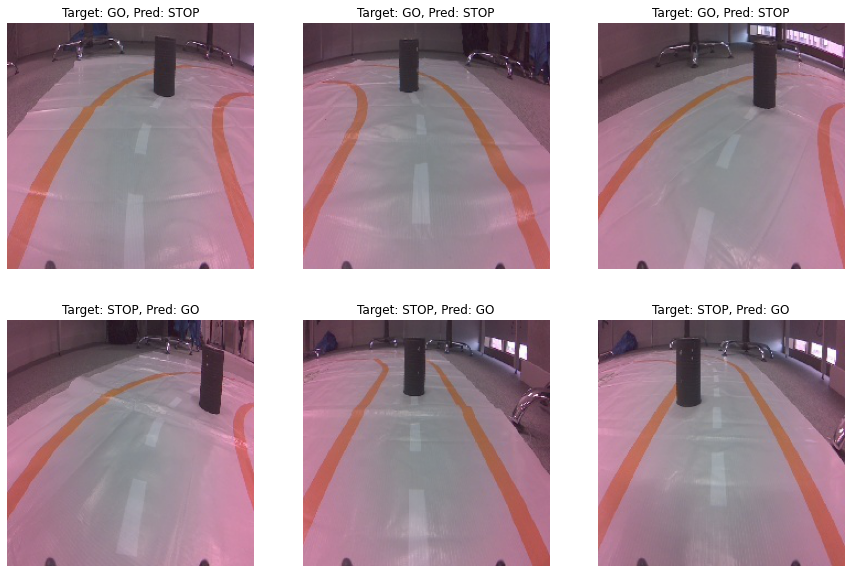

In [157]:
inc_paths = np.array(paths[split:])[np.array(target)!=np.array(prediction)]
inc_target = np.array(target)[np.array(target)!=np.array(prediction)]
inc_prediction = np.array(prediction)[np.array(target)!=np.array(prediction)]

fig, axs  = plt.subplots(2, 3, figsize=(15, 10))
fig.set_facecolor('white')

i = 0
# False positives
for j in range(len(inc_paths))[1:]:
    if (inc_target[j] == 0) & (i < 3):
        image = Image.open(inc_paths[j])
        axs[0,i].imshow(image)
        axs[0,i].set_title("Target: GO, Pred: STOP")
        axs[0,i].axis('off')
        i += 1

i = 0
# False negatives
for j in range(len(inc_paths)):
    if (inc_target[j] == 1) & (i < 3):
        image = Image.open(inc_paths[j])
        axs[1,i].imshow(image)
        axs[1,i].set_title("Target: STOP, Pred: GO")
        axs[1,i].axis('off')
        i += 1

path = "/Users/conorosullivan/Google Drive/My Drive/Medium/PyTorch Classification/errors.png"
plt.savefig(path,facecolor='white',bbox_inches='tight')

# Fine tune resnet18


In [153]:
output_dim = 2 # 0 or 1
device = torch.device('mps') # or 'cuda' if you have a GPU

# RESNET 18
model = torchvision.models.resnet18(pretrained=True)
model.fc = torch.nn.Linear(512, output_dim)
model = model.to(device)

optimizer = torch.optim.Adam(model.parameters())

The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.


In [ ]:
name = "object_detection_resnet" # Change this to save a new model

# Train the model
min_loss = np.inf
for epoch in range(50):

    model = model.train()
    for images, target in iter(train_loader):

        images = images.to(device)
        target = target.to(device)
        
        # Zero gradients of parameters
        optimizer.zero_grad()  

        # Execute model to get outputs
        output = model(images)

        # Calculate loss
        loss = torch.nn.functional.binary_cross_entropy_with_logits(output, target)

        # Run backpropogation to accumulate gradients
        loss.backward()

        # Update model parameters
        optimizer.step()

    # Calculate validation loss
    model = model.eval()

    images, target = next(iter(valid_loader))
    images = images.to(device)
    target = target.to(device)

    output = model(images)
    valid_loss = torch.nn.functional.binary_cross_entropy_with_logits(output, target)

    print("Epoch: {}, Validation Loss: {}".format(epoch, valid_loss.item()))
    
    if valid_loss < min_loss:
        print("Saving model")
        torch.save(model, '../../models/{}.pth'.format(name))

        min_loss = valid_loss

In [38]:
# Load saved model 
model = torch.load('../../models/object_detection_resnet.pth')
model.eval()
model.to(device)

# Get images and targets
images, target = next(iter(valid_loader))
target = [int(t[1]) for t in target]

# get predictions
images = images.to(device)
output=model(images)
prediction = [0 if o[0]> 0.5 else 1 for o in output]

# Evaluate
acc = metrics.accuracy_score(target,prediction)
prec,rec,_,_ = score(target, prediction,average='macro')

print('Accuracy: {}'.format(round(acc,4)))
print('Precision: {}'.format(round(prec,4)))
print('Recall: {}'.format(round(rec,4)))

fig = plt.figure(figsize=(5,5))
fig.set_facecolor('white')

# Plot confusion matrix
cm = metrics.confusion_matrix(target, prediction)
cm_display = cmd(cm, display_labels = ['GO', 'STOP'])

cm_display.plot()

path = "/Users/conorosullivan/Google Drive/My Drive/Medium/PyTorch Classification/resnet_cm.png"
plt.savefig(path,facecolor='white',bbox_inches='tight')

## Explaining model with SHAP

In [154]:
# Load saved model 
model = torch.load('../../models/object_detection_cnn.pth') #change for different model
model.eval()

# Use CPU
device = torch.device('cpu')
model = model.to(device)

#Load 100 images for background
shap_loader = DataLoader(train_data, batch_size=100, shuffle=True)
background, _ = next(iter(shap_loader))
background = background.to(device)

#Create SHAP explainer 
explainer = shap.DeepExplainer(model, background)

In [155]:
output = model(test_input)
[0 if o[0]> 0.5 else 1 for o in output]

[0, 0, 1]

The input object of type 'JpegImageFile' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'JpegImageFile', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.


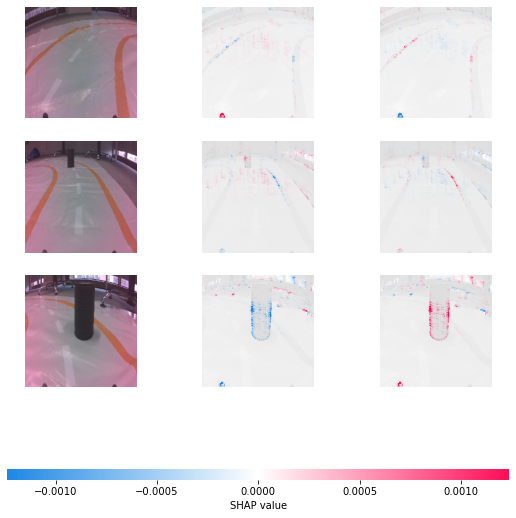

In [156]:
# Load test images
test_images = [Image.open(path) for path in ex_paths]
test_images = np.array(test_images)

test_input = [TRANSFORMS(img) for img in test_images]
test_input = torch.stack(test_input).to(device)

# Get SHAP values
shap_values = explainer.shap_values(test_input)

# Reshape shap values and images for plotting
shap_numpy = list(np.array(shap_values).transpose(0,1,3,4,2))
test_numpy = np.array([np.array(img) for img in test_images])

shap.image_plot(shap_numpy, test_numpy,show=False)

path = "/Users/conorosullivan/Google Drive/My Drive/Medium/PyTorch Classification/SHAP.png"
plt.savefig(path,facecolor='white',dpi=300,bbox_inches='tight')

# Archive

In [ ]:
# define the CNN architecture
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()

        # Convolutional layers
        # Sees 224x224x3 image tensor
        self.conv1 = nn.Conv2d(3, #RGB channels
                               16, #number of kernels
                               3, #size of kernels
                               padding=1) 

        # Sees 112x112x16 tensor
        self.conv2 = nn.Conv2d(16, 32, 3, padding=1)
        # Sees 56x56x32 tensor
        self.conv3 = nn.Conv2d(32, 64, 3, padding=1)

        # Linear layers
        # Sees flattened 28 * 28 * 64 tensor
        self.fc1 = nn.Linear(64 * 28 * 28, 500)
        # Sees 500 tensor
        self.fc2 = nn.Linear(500, 2)

        # max pooling 
        self.pool = nn.MaxPool2d(2, 2)
        # dropout  (p=0.25)
        self.dropout = nn.Dropout(0.25)

    def forward(self, x):
        # add sequence of convolutional and max pooling layers
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))

        # flatten image input
        x = x.view(-1, 64 * 28 * 28)
        # add dropout layer
        x = self.dropout(x)
        # add 1st hidden layer, with relu activation function
        x = F.relu(self.fc1(x))
        # add dropout layer
        x = self.dropout(x)
        # add 2nd hidden layer
        x = F.sigmoid(self.fc2(x))
        return x